# BVP

In [3]:
import numpy as np
import matplotlib.pylab as plt

In [4]:
from scipy.integrate import solve_bvp
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

In [5]:
from scipy.optimize import minimize_scalar

# Parameters

In [6]:
length = 100   # cm, half length of the beam
delta = 0.1  # cm, deflection at the center

E_Young = 100000 # ua

x_mesh = np.linspace(0, length, 17)  # Mesh for bvp_solve

t_max = 6
t_min = 1

In [7]:
resistivity_upper_limit = length/t_min
resistivity_lower_limit = length/t_max

stress_upper_limit = E_Young* 3* t_max*delta/length**2 / 2
stress_lower_limit = E_Young* 3* t_min*delta/length**2 / 2

In [8]:
resistivity_lower_limit

16.666666666666668

In [9]:
class Beam():
    
    def __init__(self, thickness_values):
        ''' Define a beam
            
            thickness_values: list of thickness values uniformly distributed between 0 and x=length
        '''
        self.thickness_values = thickness_values
        
        self.x_spline = np.linspace(0, length, len(thickness_values))

        self.thickness = CubicSpline(self.x_spline, thickness_values,
                                    bc_type=('natural', 'natural'))#'clamped'))
        R, err = quad(lambda x:1/self.thickness(x, nu=0),
                                0, length)
        self.resistivity = R #float(self.thickness.integrate(0, length))
        self.solve_meca()
        
    def flex(self, x):
        ''' Variable flexural rigidity and its derivatives '''
        E = E_Young / 12
        t = self.thickness(x, nu=0)
        dtdx = self.thickness(x, nu=1)
        
        D = E * t**3 
        dD_dx = E * 3*t**2 * dtdx
        d2D_dx2 = E*( 6*t*dtdx**2 + 3*t**2 * self.thickness(x, nu=2) )
        
        return D, dD_dx, d2D_dx2
  

    def solve_meca(self):
        
        def dU_dx(x, U):
            w = U[0]
            dw_dx = U[1]
            d2w_dx2 = U[2]
            d3w_dx3 = U[3]

            D, dD_dx, d2D_dx2 = self.flex(x)
            d4w_dx4 = ( -d2D_dx2*d2w_dx2 -2*dD_dx*d3w_dx3 )/D
            return np.vstack((dw_dx, d2w_dx2, d3w_dx3, d4w_dx4))
        
        def boundary_conditions(ya, yb):
            return np.array([ya[0],  # w(0) = 0
                             ya[1],  # w'(0) = 0
                             yb[0] - delta, # w(L) = delta
                             yb[2]])  # w''(L) = 0
        
        U_zero = np.ones((4, x_mesh.size))
        sol = solve_bvp(dU_dx, boundary_conditions,
                    x_mesh, U_zero)
        
        self.x = sol.x
        self.w = sol.y[0]
        self.k = sol.y[2]
        
        self.sigma =  E_Young * sol.y[2] * self.thickness(self.x)/2
        
        res = minimize_scalar(lambda x:-sol.sol(x)[2]*self.thickness(x)/2*E_Young,
                                         bounds=[0, length], method='Bounded')
        self.max_stress = -res.fun
        
        return sol
    
    
    def merite(self):

        return ((self.resistivity-resistivity_lower_limit)/(resistivity_upper_limit-resistivity_lower_limit),
               (self.max_stress- stress_lower_limit)/(stress_upper_limit -  stress_lower_limit))

## Define variable flexural rigidity

In [10]:
b_ref = Beam((6, 6))
b_half_lin = Beam((3, 6))
b_half_const = Beam((3, 3))

In [11]:
b_ref.merite()

(0.0, 0.999999944852803)

In [12]:
from scipy.optimize import minimize

In [13]:
def fun(points):
    resistivity, stress = Beam(points).merite()
    
    return resistivity**2 + stress**2

In [53]:
opti = res.x

opti_beam = Beam(opti)

plt.plot(x_mesh, opti_beam.thickness(x_mesh), '-+', label='opti');
plt.axhline(y=0);

NameError: name 'res' is not defined

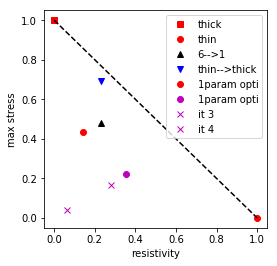

In [27]:
plt.figure(figsize=(4, 4))
plt.plot(*Beam((6, 6)).merite(), 'sr', label='thick');
plt.plot(*Beam((1, 1)).merite(), 'or', label='thin');

plt.plot(*Beam((6, 1)).merite(), '^k', label='6-->1');
plt.plot(*Beam((1, 6)).merite(), 'vb', label='thin-->thick');

# plt.plot(*Beam((6, 4, 1)).merite(), 'go', label='thin-->thick');
plt.plot(*Beam((6, 1.833)).merite(), 'ro', label='1param opti');

plt.plot(*Beam((4, 1)).merite(), 'mo', label='1param opti');

plt.plot(*Beam((2.25, 2.15, 6)).merite(), 'mx', label='it 3');

plt.plot(*Beam((2.25, 6.0, 4.125, 5.375)).merite(), 'mx', label='it 4');
#opti = [5.63575023, 5.44580001, 4.81664833, 1.75389989, 5.08693129,1.40826336]
#plt.plot(*Beam(opti).merite(), 'or', label='opti');

plt.legend();
plt.ylabel('max stress'); plt.xlabel('resistivity');
#plt.xlim([0, 1]); plt.ylim([0, 1]);
plt.plot([0, 1], [1, 0], '--k');

### One parameter minimization:

1.8333333333333335 0.205952766373622


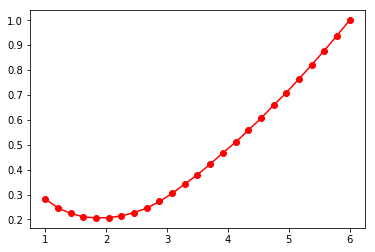

In [15]:
t_intermediate = np.linspace(1, 6, 25)
u = [fun((6, p)) for p in t_intermediate ]

plt.plot(t_intermediate, u, 'r-o');
print(t_intermediate[np.argmin(u)], min(u))

4.125 0.17424954629779432


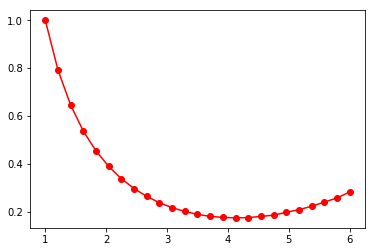

In [61]:
t_intermediate = np.linspace(1, 6, 25)
u = [fun((p, 1)) for p in t_intermediate ]

plt.plot(t_intermediate, u, 'r-o');
print(t_intermediate[np.argmin(u)], min(u))

6, 2.428571428571429:  0.3417313126626329

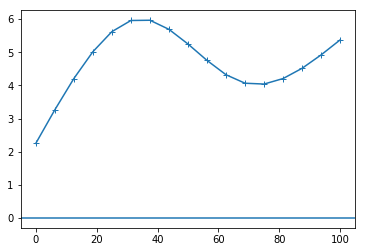

In [25]:
opti_beam = Beam((2.25, 6.0, 4.125, 5.375))

plt.plot(x_mesh, opti_beam.thickness(x_mesh), '-+', label='opti');
plt.axhline(y=0);

In [16]:
fun((6, 6, 1, 6, 6))

1.1989994772363783

In [17]:
import itertools as it

In [31]:
min_value = 0.3
for points in it.product(np.linspace(1, 6, 4), repeat=6):
    padded_points = points
    score = fun(padded_points)
    print('.', end='')
    if score < min_value:
        print('\r', end='')
        print(padded_points, '\t', score)
        min_value = score
        
print('done')

(1.0, 1.0, 1.0, 4.333333333333334, 6.0, 2.666666666666667) 	 0.2907475435152213
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 2.666666666666667, 2.666666666666667) 	 0.25599255066474114
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 2.666666666666667, 4.333333333333334) 	 0.24118068284030272
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 2.666666666666667, 6.0) 	 0.23443493174255664
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 4.333333333333334, 2.666666666666667) 	 0.21827703465991502
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 4.333333333333334, 4.333333333333334) 	 0.2085146584069813
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 4.333333333333334, 6.0) 	 0.20376970860533328
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 6.0, 2.666666666666667) 	 0.20319082524512377
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 6.0, 4.333333333333334) 	 0.19612577835971437
(1.0, 1.0, 2.666666666666667, 2.666666666666667, 6.0, 6.0) 	 0.19090285597125078
(1.0, 1.0, 2.66666666666

/home/etienne/Projets/py3/lib/python3.5/site-packages/ipykernel_launcher.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  from ipykernel import kernelapp as app


(1.0, 2.666666666666667, 1.0, 6.0, 6.0, 1.0) 	 0.13074719519429875
(1.0, 2.666666666666667, 1.0, 6.0, 6.0, 2.666666666666667) 	 0.12149767167287581
(1.0, 2.666666666666667, 1.0, 6.0, 6.0, 4.333333333333334) 	 0.11618965079537713
(1.0, 2.666666666666667, 1.0, 6.0, 6.0, 6.0) 	 0.11323522692966996
(1.0, 2.666666666666667, 2.666666666666667, 4.333333333333334, 1.0, 6.0) 	 0.10481045975734811
(1.0, 2.666666666666667, 2.666666666666667, 6.0, 1.0, 6.0) 	 0.09536949501793998
(1.0, 2.666666666666667, 2.666666666666667, 6.0, 2.666666666666667, 1.0) 	 0.09173781289156856
(1.0, 2.666666666666667, 2.666666666666667, 6.0, 2.666666666666667, 2.666666666666667) 	 0.060404341537228824
(1.0, 2.666666666666667, 2.666666666666667, 6.0, 2.666666666666667, 4.333333333333334) 	 0.04962356139239631
(1.0, 2.666666666666667, 2.666666666666667, 6.0, 2.666666666666667, 6.0) 	 0.04518010154362063
(1.0, 2.666666666666667, 2.666666666666667, 6.0, 4.333333333333334, 2.666666666666667) 	 0.039818117379541954
(1.0, 2.6

/home/etienne/Projets/py3/lib/python3.5/site-packages/ipykernel_launcher.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  from ipykernel import kernelapp as app


(1.0, 6.0, 6.0, 4.333333333333334, 4.333333333333334, 1.0) 	 0.013460429262800727
(1.0, 6.0, 6.0, 4.333333333333334, 4.333333333333334, 2.666666666666667) 	 0.008431356970781461
(1.0, 6.0, 6.0, 4.333333333333334, 4.333333333333334, 4.333333333333334) 	 0.006597631586557991
(1.0, 6.0, 6.0, 4.333333333333334, 4.333333333333334, 6.0) 	 0.005879933613196786
(1.0, 6.0, 6.0, 4.333333333333334, 6.0, 6.0) 	 0.0050492101735439
(2.666666666666667, 4.333333333333334, 6.0, 4.333333333333334, 6.0, 4.333333333333334) 	 0.0045972607820709745
(2.666666666666667, 4.333333333333334, 6.0, 4.333333333333334, 6.0, 6.0) 	 0.004205664634457144
...................................................................................................................................................................................................................................................................................................................................................................................

/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:1082: RuntimeWarning: invalid value encountered in true_divide
  r_middle = 1.5 * col_res / h
/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:595: RuntimeWarning: invalid value encountered in true_divide
  slope = (y[:, 1:] - y[:, :-1]) / h
/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:1092: RuntimeWarning: invalid value encountered in greater
  insert_1, = np.nonzero((rms_res > tol) & (rms_res < 100 * tol))
/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:1092: RuntimeWarning: invalid value encountered in less
  insert_1, = np.nonzero((rms_res > tol) & (rms_res < 100 * tol))
/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:1093: RuntimeWarning: invalid value encountered in greater_equal
  insert_2, = np.nonzero(rms_res >= 100 * tol)


(6.0, 2.666666666666667, 6.0, 4.333333333333334, 6.0, 6.0) 	 0.004049169326154605
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done


In [69]:
minimize(fun, padded_points, method='Powell')

/home/etienne/Projets/py3/lib/python3.5/site-packages/ipykernel_launcher.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  from ipykernel import kernelapp as app
/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:1082: RuntimeWarning: invalid value encountered in true_divide
  r_middle = 1.5 * col_res / h
/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:595: RuntimeWarning: invalid value encountered in true_divide
  slope = (y[:, 1:] - y[:, :-1]) / h
/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:1092: RuntimeWarning: invalid value encountered in greater
  insert_1, = np.nonzero((rms_res > tol) & (rms_res < 100 * tol))
/home/etienne/Projets/py3/lib/python3.5/site-packages/scipy/integrate/_bvp.py:1092: RuntimeWarning: invalid value encountered in less
  insert_1, = np.nonzero((rms_res > tol) & (rms_res < 100 * tol))
/home/etienne/Projets/py3/lib/python3.5/site-pack

KeyboardInterrupt: 

In [15]:
min_value = 0.8
for points in it.product(np.linspace(1, 6, 4), repeat=3):
    score = fun(points)
    if score < min_value:
        print(points, score)
        min_value = score

(1.0, 1.0, 4.333333333333334) 0.7666610017607789
(1.0, 1.0, 6.0) 0.6614425712746769
(1.0, 2.666666666666667, 6.0) 0.5163840674139417
(2.666666666666667, 2.666666666666667, 4.333333333333334) 0.4513929712887476
(2.666666666666667, 2.666666666666667, 6.0) 0.35923784557237864
(6.0, 4.333333333333334, 2.666666666666667) 0.3490885376340931


In [ ]:
res

0.005785459513587985
0.005169468475525467


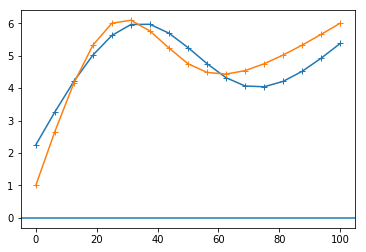

In [30]:
opti_points = (2.25, 6.0, 4.125, 5.375)
opti_beam = Beam(opti_points)
print(fun(opti_points))
plt.plot(x_mesh, opti_beam.thickness(x_mesh), '-+', label='opti');

opti_points = (1.0, 6.0, 4.75, 4.75, 6.0)
opti_beam = Beam(opti_points)
print(fun(opti_points))
plt.plot(x_mesh, opti_beam.thickness(x_mesh), '-+', label='opti');
plt.axhline(y=0);

In [41]:
4 and 5

5

In [43]:
not 0

True